In [1]:
import os.path

import scmdata
import xarray as xr
from openscm_runner import run
from mesmer_openscmrunner.draw_realisations import _draw_realisations_from_mesmer_file_and_openscm_output

<IPython.core.display.Javascript object>

/Users/znicholls/miniconda3/envs/mesmer-openscmrunner/lib/python3.9/site-packages/openscm_runner/progress.py:5: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
RUN_MAGICC = False
INPUT_SCENARIOS_FILE = "rcmip_scen_ssp_world_emissions.csv"

In [3]:
if RUN_MAGICC:
    # see docs in get-magicc.sh for instructions about how to get links needed below
    !MAGICC7_LINK="<magicc-link>" MAGICC7_AR6_PARAMETER_SET="<magicc-parameter-set-link>" bash get-magicc.sh

In [4]:
if RUN_MAGICC:
    input_scenarios = scmdata.ScmRun(INPUT_SCENARIOS_FILE, lowercase_cols=True).filter(scenario=["ssp126", "ssp585"])
    ax = input_scenarios.filter(variable="Emissions|CO2*").convert_unit("GtC / yr").lineplot(style="variable")
    ax.legend(loc="center left", bbox_to_anchor=(1.05, 0.5))

In [5]:
if RUN_MAGICC:
    # unix
    os.environ["MAGICC_EXECUTABLE_7"] = os.path.join("magicc-bits-and-pieces", "magicc-v7.5.3", "bin", "magicc")
    # windows
    os.environ["MAGICC_EXECUTABLE_7"] = os.path.join("magicc-bits-and-pieces", "magicc-v7.5.3", "bin", "magicc.exe")
    # mac
    # ask Zeb for binary
    os.environ["MAGICC_EXECUTABLE_7"] = os.path.join("magicc-bits-and-pieces", "magicc-v7.5.3", "bin", "magicc_mac")

    # where to create MAGICC workers
    os.environ["MAGICC_WORKER_ROOT_DIR"] = "/tmp"

    res = run(
        output_variables=('Surface Temperature',),
        scenarios=input_scenarios,
        climate_models_cfgs={
            "MAGICC7": [
                {
                    "core_climatesensitivity": ecs,
                    "run_id": i,
                }
                for i, ecs in enumerate([2, 3, 4])
            ]
        }
    )
    res.metadata = {}
    res.filter(region="World").to_nc("magicc_global_output.nc", dimensions=("scenario", "run_id"), extras=("model",))

In [6]:
magicc_output = scmdata.ScmRun.from_nc("magicc_global_output.nc")
magicc_output

<ScmRun (timeseries: 6, timepoints: 336)>
Time:
	Start: 1765-01-01T00:00:00
	End: 2100-01-01T00:00:00
Meta:
	  climate_model          model region  run_id scenario unit  \
	0  MAGICCv7.5.3          IMAGE  World       0   ssp126    K   
	1  MAGICCv7.5.3  REMIND-MAGPIE  World       0   ssp585    K   
	2  MAGICCv7.5.3          IMAGE  World       1   ssp126    K   
	3  MAGICCv7.5.3  REMIND-MAGPIE  World       1   ssp585    K   
	4  MAGICCv7.5.3          IMAGE  World       2   ssp126    K   
	5  MAGICCv7.5.3  REMIND-MAGPIE  World       2   ssp585    K   
	
	                         variable  
	0  Surface Air Temperature Change  
	1  Surface Air Temperature Change  
	2  Surface Air Temperature Change  
	3  Surface Air Temperature Change  
	4  Surface Air Temperature Change  
	5  Surface Air Temperature Change  

In [7]:
test_data_dir = os.path.join("..", "tests", "test-data")
mesmer_bundle_file = os.path.join(
    test_data_dir, "mesmer-bundles", "test-generic-mesmer-bundle.pkl"
)

Annoyingly, the current draw realisations interface expects only one ensemble member per scenario from the MAGICC (or other reduced complexity model) output so we have to do a loop here. This could definitely be improved.

In [8]:
mesmer_draws = []
for ensemble_member in magicc_output.groupby("run_id"):
    # yes, would be nicer if our groupby behaved more like pandas, PRs welcome...
    em = ensemble_member.get_unique_meta("run_id")
    
    mesmer_draws_ensemble_member = _draw_realisations_from_mesmer_file_and_openscm_output(
        mesmer_bundle_file=mesmer_bundle_file,
        openscm_gsat=ensemble_member,
        seeds={"IPSL-CM6A-LR": {"all": {"gv": 0, "lv": 1000000}}},
        n_realisations_per_scenario=3,
        predictors=("gttas",),
    ).expand_dims(magicc_ensemble_member=em)
    mesmer_draws.append(mesmer_draws_ensemble_member)
    

mesmer_draws = xr.merge(mesmer_draws)
mesmer_draws

Start with OLS
Start with AR(1) with spatially correlated innovations.
Draw the innovations
Compute the contribution to emus_lv by the AR(1) process with the spatially correlated innovations
Create the full local variability emulations
Start with OLS
Start with AR(1) with spatially correlated innovations.
Draw the innovations
Compute the contribution to emus_lv by the AR(1) process with the spatially correlated innovations
Create the full local variability emulations
Start with OLS
Start with AR(1) with spatially correlated innovations.
Draw the innovations
Compute the contribution to emus_lv by the AR(1) process with the spatially correlated innovations
Create the full local variability emulations
Start with OLS
Start with AR(1) with spatially correlated innovations.
Draw the innovations
Compute the contribution to emus_lv by the AR(1) process with the spatially correlated innovations
Create the full local variability emulations
Start with OLS
Start with AR(1) with spatially correlate

<xarray.Dataset>
Dimensions:                 (magicc_ensemble_member: 3, scenario: 2,
                             realisation: 3, year: 251, z: 118)
Coordinates:
  * magicc_ensemble_member  (magicc_ensemble_member) int64 0 1 2
  * scenario                (scenario) <U6 'ssp126' 'ssp585'
  * realisation             (realisation) int64 0 1 2
  * year                    (year) int64 1850 1851 1852 1853 ... 2098 2099 2100
    lat                     (z) float64 -49.5 -40.5 -31.5 ... 76.5 76.5 76.5
    lon                     (z) float64 -72.0 -72.0 -72.0 ... -18.0 90.0 108.0
Dimensions without coordinates: z
Data variables:
    tas                     (magicc_ensemble_member, scenario, realisation, year, z) float64 ...

In [9]:
mesmer_draws_stacked = mesmer_draws.set_index(z=("lat", "lon")).unstack("z")
mesmer_draws_stacked

<xarray.Dataset>
Dimensions:                 (magicc_ensemble_member: 3, scenario: 2,
                             realisation: 3, year: 251, lat: 15, lon: 20)
Coordinates:
  * magicc_ensemble_member  (magicc_ensemble_member) int64 0 1 2
  * scenario                (scenario) <U6 'ssp126' 'ssp585'
  * realisation             (realisation) int64 0 1 2
  * year                    (year) int64 1850 1851 1852 1853 ... 2098 2099 2100
  * lat                     (lat) float64 -49.5 -40.5 -31.5 ... 58.5 67.5 76.5
  * lon                     (lon) float64 -180.0 -162.0 -144.0 ... 144.0 162.0
Data variables:
    tas                     (magicc_ensemble_member, scenario, realisation, year, lat, lon) float64 ...

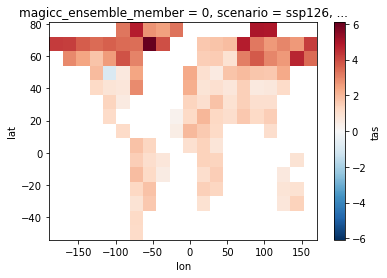

In [10]:
mesmer_draws_stacked.sel(magicc_ensemble_member=0, scenario="ssp126", realisation=1, year=2100)["tas"].plot()

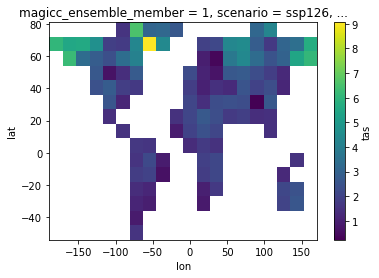

In [11]:
mesmer_draws_stacked.sel(magicc_ensemble_member=1, scenario="ssp126", realisation=0, year=2100)["tas"].plot()